In [1]:
import os
os.chdir("../")

# Inferencing First Stage Model

In [2]:
import random
import torch
from torchvision import transforms
from omegaconf import OmegaConf
from functools import partial
from utils import load_checkpoint, instantiate_object
from matplotlib import pyplot as plt

/Users/temiloluw.adeoti/codes-and-scripts/exploration/image-synthesis-models/lsm-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/temiloluw.adeoti/codes-and-scripts/exploration/image-synthesis-models/lsm-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CONSTANTS

CONFIG = "hyperparameters/autoencoder/config.yaml"
CKPT = "ckpts/date=2024-11-16T07-16-53/dataset=ryan-sjtu-celebahq-caption/autoencoder-epoch=16-val_loss=9271.40.ckpt"

config = OmegaConf.load(CONFIG)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") 

### Load Autoencoder

In [4]:
autoencoder = load_checkpoint(config.model, CKPT).to(device)
autoencoder.eval()

print(f"Autoencoder device: {autoencoder.device}")

Autoencoder device: mps


### Load Samples from Val set

In [5]:
datamodule = instantiate_object(config.data)
datamodule.setup("test")

In [6]:
batch_size = datamodule.batch_size
dl = datamodule.test_dataloader()

print(f"The test dataloader has {len(dl)} batches of size {batch_size}")
print(f"Total number of samples: {len(dl) * batch_size}")

The test dataloader has 188 batches of size 16
Total number of samples: 3008


### Helpers

In [7]:
def tensor_to_pil(tensor, image_size: int=512):
    tensor = tensor * 0.5 + 0.5
    tensor = torch.clamp(tensor, 0, 1)
    
    return transforms.Compose([
        transforms.ToPILImage()
    ])(tensor)

def visualize_batch(input_batch, output_batch, num_samples=5):
    num_samples = min(num_samples, input_batch.size(0))

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        input_image = tensor_to_pil(input_batch[i])
        output_image = tensor_to_pil(output_batch[i])

        axes[i, 0].imshow(input_image)
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(output_image)
        axes[i, 1].set_title('Output')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

tensor_to_pil = partial(tensor_to_pil, image_size=config.shared_configs.image_size)

### Visualize Images

In [8]:
num_images = 3
random_indices = random.sample(range(len(dl) * batch_size), num_images)
x = torch.stack([dl.dataset[i][0] for i in random_indices]).to(device)

print(f"Input shape: {x.shape}")

Input shape: torch.Size([3, 3, 256, 256])


In [9]:
o, mean, log_var = autoencoder(x)
print(f"Output shape: {o.shape}, mean shape: {mean.shape}, log_var shape: {log_var.shape}")

Output shape: torch.Size([3, 3, 256, 256]), mean shape: torch.Size([3, 1024]), log_var shape: torch.Size([3, 1024])


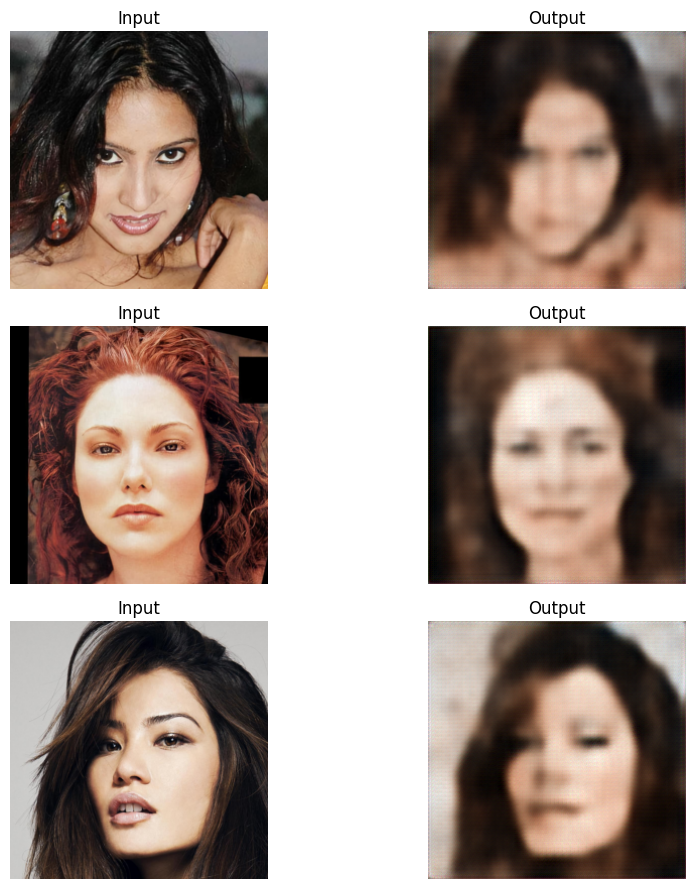

In [10]:
visualize_batch(x, o, num_samples=num_images)

In [14]:
def predict_preturbed(x, 
                    num_perturbations=5, 
                    perturbation_scale=0.5):
    z, _, _ = autoencoder.encode(x)
    perturbed_latents = [z + perturbation_scale * torch.randn_like(z) for _ in range(num_perturbations)]
    outputs = [autoencoder.decode(z) for z in perturbed_latents]

    return outputs


In [35]:
pertubed_outputs = predict_preturbed(x, num_perturbations=5, perturbation_scale=0.9)

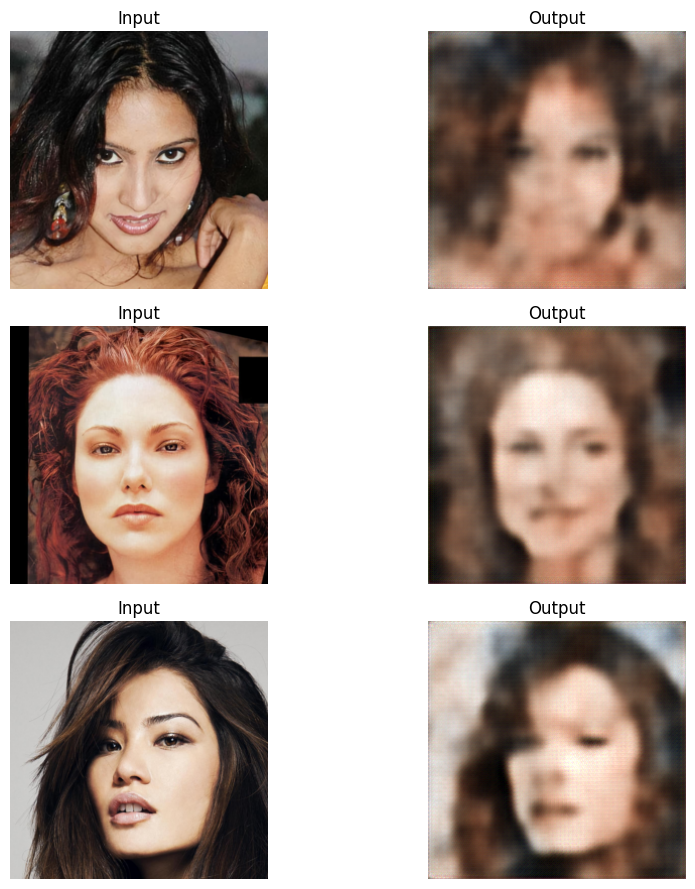

In [36]:
visualize_batch(x, pertubed_outputs[2])